In [1]:
#library(Hmisc)
suppressWarnings(library(zoo))
suppressWarnings(library(Hmisc))
suppressMessages(library(pracma))



Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units

Warning message:
"package 'pracma' was built under R version 3.6.3"

### Read data

In [2]:
df = read.table("airlines_passengers_data.csv",sep=',',header=1)

In [3]:
head(df)

Month,Passengers
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
1949-06,135


In [4]:
describe(df)

df 

 2  Variables      144  Observations
--------------------------------------------------------------------------------
Month 
       n  missing distinct 
     144        0      144 

lowest : 1949-01 1949-02 1949-03 1949-04 1949-05
highest: 1960-08 1960-09 1960-10 1960-11 1960-12
--------------------------------------------------------------------------------
Passengers 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
     144        0      118        1    280.3    135.9    121.6    135.3 
     .25      .50      .75      .90      .95 
   180.0    265.5    360.5    453.2    488.1 

lowest : 104 112 114 115 118, highest: 535 548 559 606 622
--------------------------------------------------------------------------------

In [5]:
# create date feature from year and month
yr <- substr(df$Month,1,4)
mo <- substr(df$Month,6,7)
dates <- as.Date(paste(yr,mo,'01',sep="-"))

In [6]:
# create zoo object
df_2 = zoo(df$Passengers,order.by=dates)

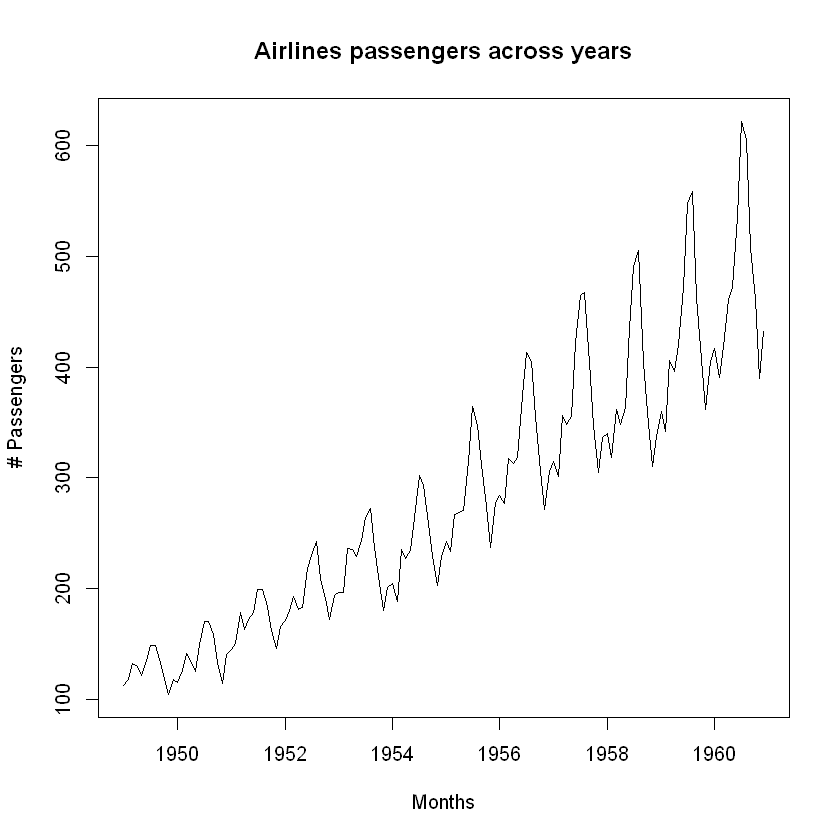

In [7]:
# plot time series
plot(df_2,xlab="Months",ylab="# Passengers",main="Airlines passengers across years")

In [8]:
# take log to remove increasing variance in seasonality
df_2_log = zoo(log(df$Passengers),order.by=dates)

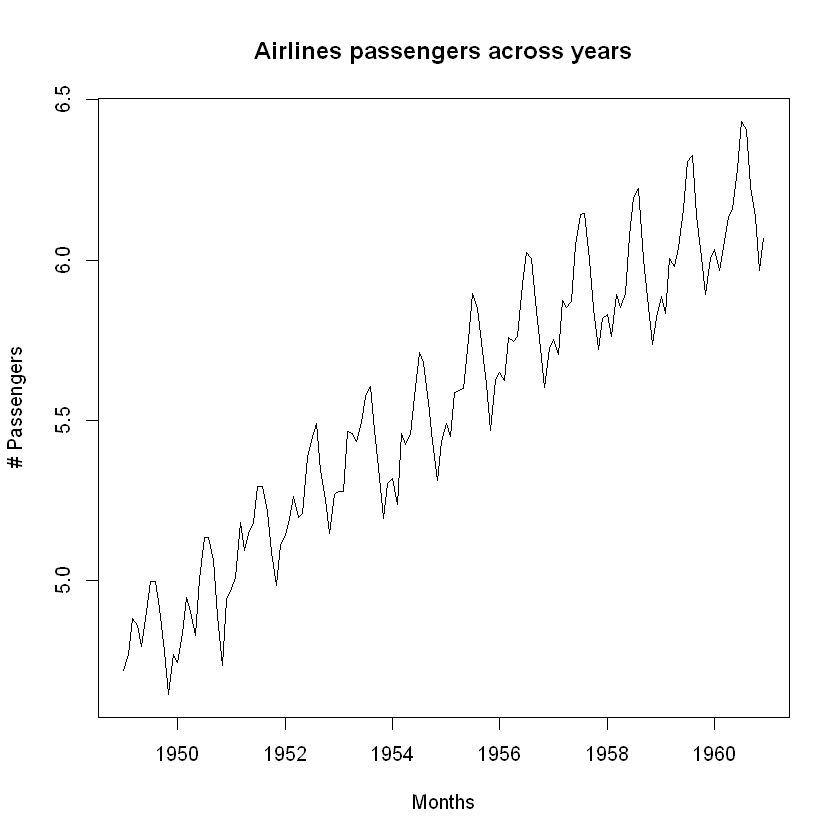

In [9]:
# plot time series
plot(df_2_log,xlab="Months",ylab="# Passengers",main="Airlines passengers across years")

In [10]:
# par(mfrow=c(2,2))
# plot(df_2_log[1:12],xlab="Months",ylab="# Passengers",main=min(yr[1:12]))
# plot(df_2_log[13:24],xlab="Months",ylab="# Passengers",main=min(yr[13:24]))
# plot(df_2_log[25:36],xlab="Months",ylab="# Passengers",main=min(yr[25:36]))
# plot(df_2_log[37:48],xlab="Months",ylab="# Passengers",main=min(yr[37:48]))

### Calculating Periodogram by hand

In [11]:
# remove trend from data
df_detrend = data.frame("Passengers"=detrend(log(df$Passengers), 'linear'))
head(df_detrend)

Passengers
-0.105217793
-0.063080421
0.038988495
0.005950595
-0.068119645
0.031316206


In [12]:
# create zoo object
df_detrend = zoo(df_detrend$Passengers,order.by=dates)

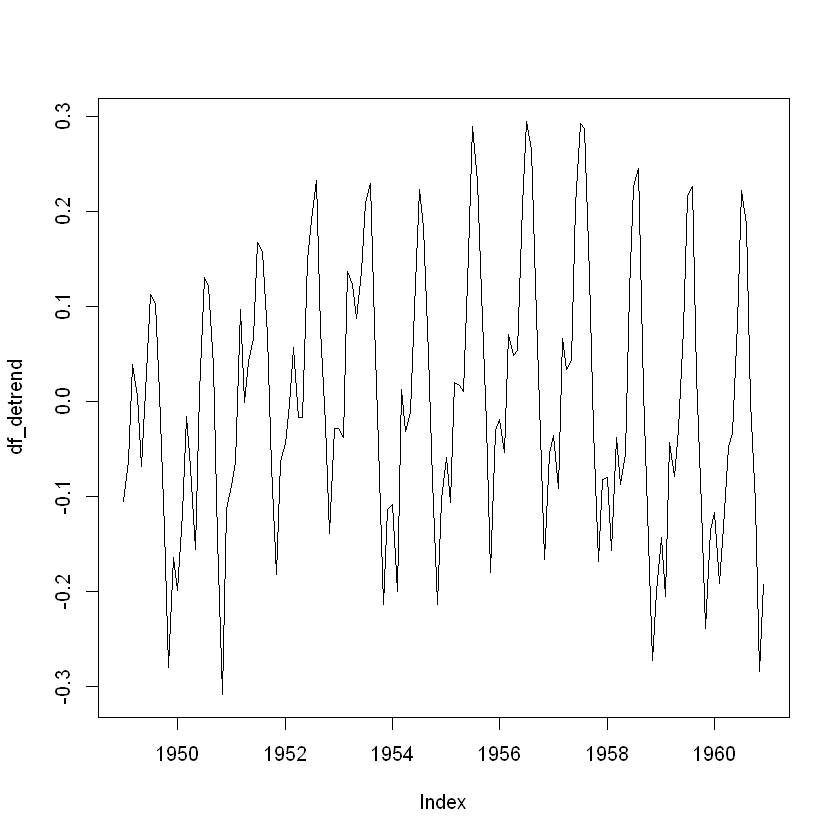

In [13]:
# plot detrended time series
plot(df_detrend)

### Fourier transform

In [16]:
# get fourier transform of time series
fft_df = fft(df_detrend)
fft_df[1:10]
n = length(fft_df)

                 1949-01-01                  1949-02-01 
-2.042810e-14+0.000000e+00i -3.413459e+00+1.836112e-01i
                 1949-03-01                  1949-04-01 
-1.385319e+00-5.684846e-01i  1.836019e+00+1.359261e+00i
                 1949-05-01                  1949-06-01 
 8.815098e-02+2.633051e-02i  1.121880e-01+7.153653e-01i
                 1949-07-01                  1949-08-01 
 6.001707e-01-9.846591e-01i  2.247522e-02-5.483008e-01i
                 1949-09-01                  1949-10-01 
 2.532679e-01+4.666718e-01i  1.001089e-01-3.796122e-01i

In [17]:
# FFT values are symmetric
print(paste(c("2nd Fourier coefficient " ,as.character(fft_df[2]) ,"144th Fourier coefficient " ,as.character(fft_df[n]))))
print(paste(c("3rd Fourier coefficient " ,as.character(fft_df[3]) ,"143th Fourier coefficient " ,as.character(fft_df[n-1]))))


[1] "2nd Fourier coefficient "            "-3.41345865984196+0.18361121180606i"
[3] "144th Fourier coefficient "          "-3.41345865984196-0.18361121180607i"
[1] "3rd Fourier coefficient "            "-1.38531925117481-0.56848455637024i"
[3] "143th Fourier coefficient "          "-1.38531925117481+0.56848455637024i"


In [18]:
# FFT values are symmetric hence we only consider the fourier coffecicients till (n+1)/2 and multiply by 2

periodogram = (abs(fft_df)^2)/n
periodogram = 2*periodogram[1:((n+1)/2)]

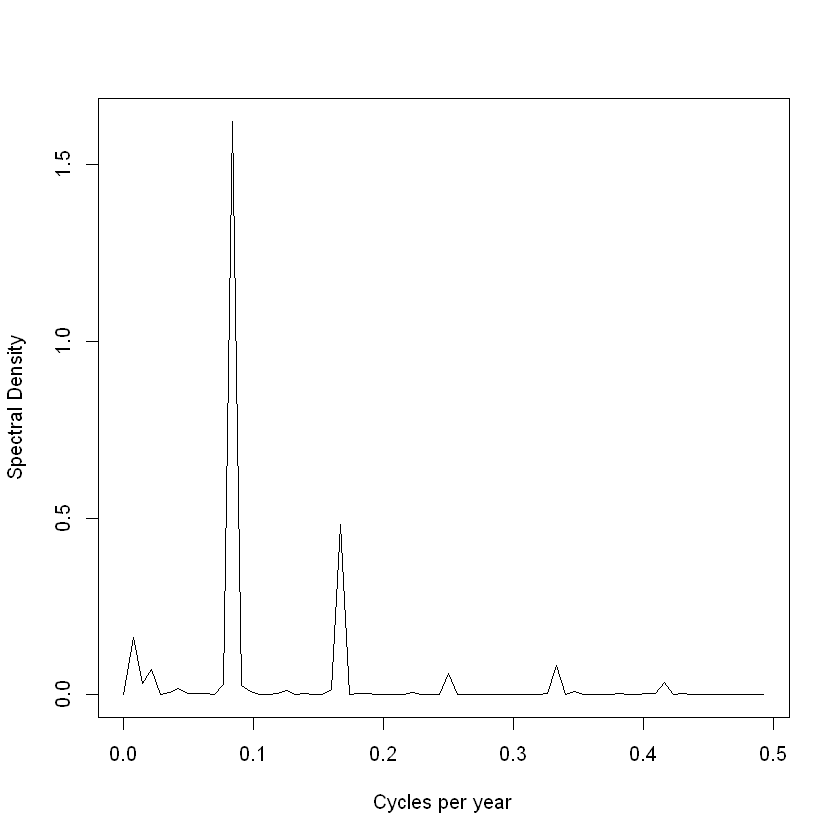

In [19]:
# plot periodogram
spec_freq =(0:((n+1)/2-1))/n
spec_perdiodogram = periodogram
plot(spec_freq, spec_perdiodogram, xlab="Cycles per year", ylab="Spectral Density", type="l")

The data shows spikes at 1 cycle per year and 2 cycle per year, which can be interpreted as an annual cycle that repeats once every year and there is a 6 month cycle that repeats twice each year.

### Spectral Analysis

**Spectrum** function in R removes any linear trend in data and estimates the strength at each frequency also known as the periodogram.

Documenatation :
https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/spectrum


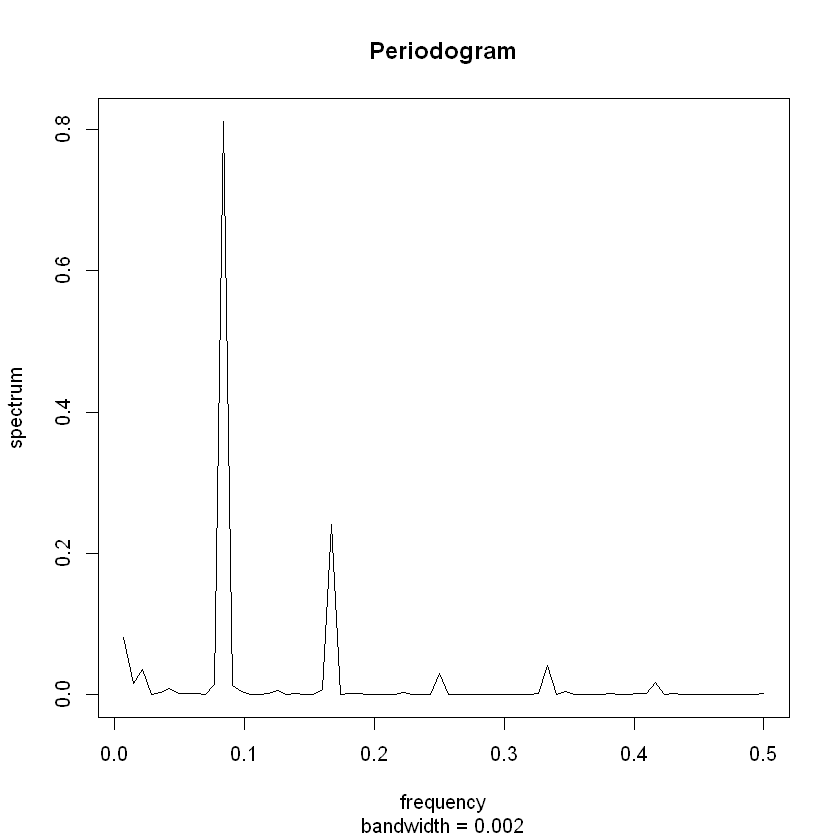

In [20]:
density_spectrum <- spectrum(log(df$Passengers),log='no',main="Periodogram",taper=0)
n = length(df$Passengers)

The frequency is number of cycles per observations, this is equivalent to cycles per month in this case as data in months.

We can convert this to cycles per quarter or cycles per year as well.

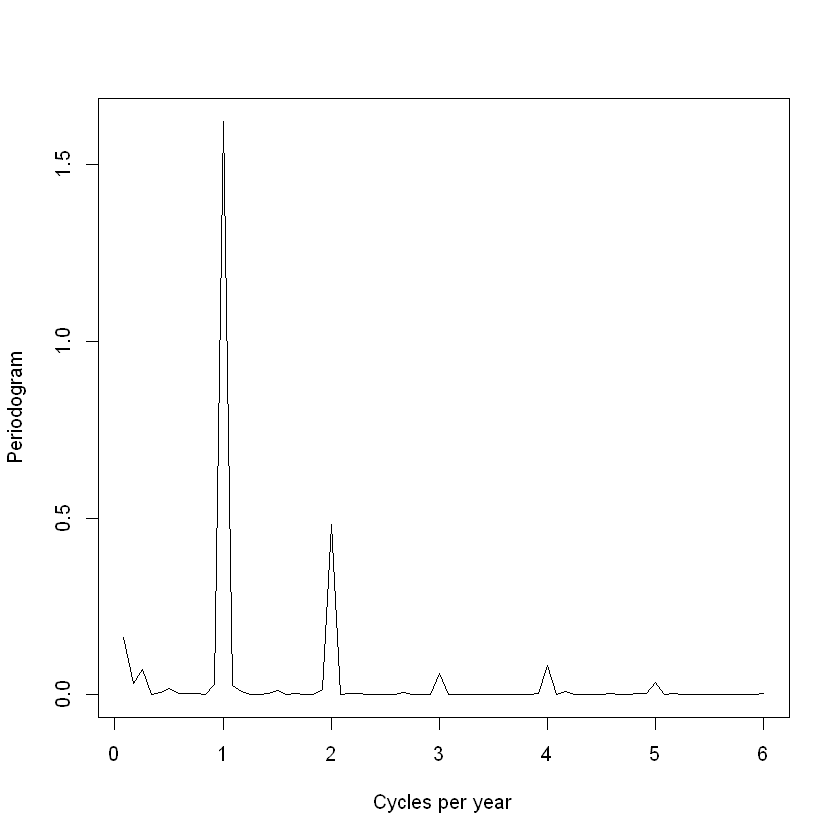

In [21]:
# frequency as cycles per year
sampling_freq = 12
spec_freq = density_spectrum$freq * sampling_freq
spec_perdiodogram = 2 * density_spectrum$spec
plot(spec_freq, spec_perdiodogram, xlab="Cycles per year", ylab="Periodogram", type="l")